# PWD 知识图谱分析与可视化

本笔记用于连接 Neo4j 数据库，执行常用的结构统计、核心实体分析、传播链查询以及质量检查，便于撰写实验报告或输出可视化素材。

In [ ]:

from neo4j import GraphDatabase
from config_loader import load_config
import pandas as pd
from IPython.display import display

config = load_config()
NEO4J_URI = config.get('neo4j.uri', 'bolt://localhost:7687')
NEO4J_USER = config.get('neo4j.user', 'neo4j')
NEO4J_PASSWORD = config.get('neo4j.password', '12345678')

print(f"Connecting to: {NEO4J_URI}")
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))


In [ ]:
def run_query(title: str, query: str):
    print(f"\n# {title}")
    print(query)
    with driver.session() as session:
        result = session.run(query)
        df = pd.DataFrame(result.data())
    if df.empty:
        print("(no results)")
    else:
        display(df)

## 1. 图谱规模与类型分布

In [ ]:

run_query(
    "1.1 节点与关系规模",
    """
MATCH (n)
WITH count(n) AS node_count
MATCH ()-[r]->()
RETURN node_count, count(r) AS rel_count;
"""
)

run_query(
    "1.2 节点类型分布",
    """
MATCH (n)
RETURN labels(n)[0] AS label, count(n) AS count
ORDER BY count DESC;
"""
)

run_query(
    "1.3 关系类型分布",
    """
MATCH ()-[r]->()
RETURN type(r) AS rel_type, count(r) AS count
ORDER BY count DESC;
"""
)

run_query(
    "1.4 关系权重统计",
    """
MATCH ()-[r]->()
WHERE r.weight IS NOT NULL
RETURN 
  min(r.weight) AS min_weight,
  max(r.weight) AS max_weight,
  avg(r.weight) AS avg_weight,
  percentileCont(r.weight, 0.5) AS median_weight,
  count(r) AS rel_count;
"""
)



# 1.1 节点与关系规模

MATCH (n)
WITH count(n) AS node_count
MATCH ()-[r]->()
RETURN node_count, count(r) AS rel_count;



,node_count,rel_count
0,59,365



# 1.2 节点类型分布

MATCH (n)
RETURN labels(n)[0] AS label, count(n) AS count
ORDER BY count DESC;



,label,count
0,Location,16
1,Host,15
2,Technology,10
3,Vector,5
4,Other,4
5,Control,3
6,EnvironmentalFactor,2
7,Pathogen,2
8,Disease,1
9,Symptom,1



# 1.3 关系类型分布

MATCH ()-[r]->()
RETURN type(r) AS rel_type, count(r) AS count
ORDER BY count DESC;



,rel_type,count
0,CO_OCCURS_WITH,299
1,RELATED_TO,12
2,PARASITIZES,6
3,TREATS,5
4,DISTRIBUTED_IN,5
5,AFFECTS,4
6,TRANSMITS,3
7,INFECTS,3
8,FEEDS_ON,3
9,LOCATED_IN,3



# 1.4 关系权重统计

MATCH ()-[r]->()
WHERE r.weight IS NOT NULL
RETURN 
  min(r.weight) AS min_weight,
  max(r.weight) AS max_weight,
  avg(r.weight) AS avg_weight,
  percentileCont(r.weight, 0.5) AS median_weight,
  count(r) AS rel_count;



,min_weight,max_weight,avg_weight,median_weight,rel_count
0,0.1,0.8,0.126913,0.1,365


## 2. 核心节点与度数分析

In [ ]:

run_query(
    "2.1 度数最高的节点",
    """
MATCH (n)
RETURN
  n.name AS name,
  labels(n)[0] AS label,
  coalesce(n.total_degree, COUNT { (n)--() }) AS degree
ORDER BY degree DESC
LIMIT 20;
"""
)

run_query(
    "2.2 度数最高的疾病节点",
    """
MATCH (n:Disease)
RETURN
  n.name AS disease,
  coalesce(n.total_degree, COUNT { (n)--() }) AS degree
ORDER BY degree DESC
LIMIT 10;
"""
)



# 2.1 度数最高的节点

MATCH (n)
RETURN
  n.name AS name,
  labels(n)[0] AS label,
  coalesce(n.total_degree, COUNT { (n)--() }) AS degree
ORDER BY degree DESC
LIMIT 20;



,name,label,degree
0,松材线虫病,Disease,49
1,松材线虫,Pathogen,42
2,日本星天牛,Vector,40
3,叶片,Symptom,35
4,黑松,Host,34
5,马尾松,Host,30
6,湿地松,Host,29
7,栎林星天牛,Vector,26
8,松材线虫相关细菌,Pathogen,25
9,诱捕器,Control,22



# 2.2 度数最高的疾病节点

MATCH (n:Disease)
RETURN
  n.name AS disease,
  coalesce(n.total_degree, COUNT { (n)--() }) AS degree
ORDER BY degree DESC
LIMIT 10;



,disease,degree
0,松材线虫病,49


## 3. 松材线虫病传播链分析

In [ ]:

run_query(
    "3.1 松材线虫病的一跳邻居",
    """
MATCH (d:Disease {name: 'pine wilt disease'})-[r]-(n)
RETURN 
  type(r) AS rel_type,
  labels(n)[0] AS neighbor_label,
  n.name AS neighbor_name,
  coalesce(r.weight, 1.0) AS weight
ORDER BY rel_type, neighbor_label, weight DESC;
"""
)

run_query(
    "3.2 传播链 (Disease -> Pathogen -> Vector -> Host)",
    """
MATCH path = (d:Disease {name: 'pine wilt disease'})
             -[:hasPathogen]->(p:Pathogen)
             -[:transmits|INFECTS*1..2]->(h:Host)
RETURN path
LIMIT 20;
"""
)

run_query(
    "3.3 症状链路",
    """
MATCH (d:Disease {name: 'pine wilt disease'})-[r:hasSymptom]->(s:Symptom)
RETURN d.name AS disease, s.name AS symptom, coalesce(r.weight, 1.0) AS weight;
"""
)

run_query(
    "3.4 环境因子影响",
    """
MATCH (d:Disease {name: 'pine wilt disease'})-[r:AFFECTED_BY]->(e:EnvironmentalFactor)
RETURN e.name AS factor, coalesce(r.weight, 1.0) AS weight
ORDER BY weight DESC;
"""
)



# 3.1 松材线虫病的一跳邻居

MATCH (d:Disease {name: 'pine wilt disease'})-[r]-(n)
RETURN 
  type(r) AS rel_type,
  labels(n)[0] AS neighbor_label,
  n.name AS neighbor_name,
  coalesce(r.weight, 1.0) AS weight
ORDER BY rel_type, neighbor_label, weight DESC;

(no results)

# 3.2 传播链 (Disease -> Pathogen -> Vector -> Host)

MATCH path = (d:Disease {name: 'pine wilt disease'})
             -[:hasPathogen]->(p:Pathogen)
             -[:transmits|INFECTS*1..2]->(h:Host)
RETURN path
LIMIT 20;

(no results)

# 3.3 症状链路

MATCH (d:Disease {name: 'pine wilt disease'})-[r:hasSymptom]->(s:Symptom)
RETURN d.name AS disease, s.name AS symptom, coalesce(r.weight, 1.0) AS weight;

(no results)

# 3.4 环境因子影响

MATCH (d:Disease {name: 'pine wilt disease'})-[r:AFFECTED_BY]->(e:EnvironmentalFactor)
RETURN e.name AS factor, coalesce(r.weight, 1.0) AS weight
ORDER BY weight DESC;

(no results)


## 4. 防治措施统计

In [ ]:

run_query(
    "4.1 针对松材线虫病的防治措施",
    """
MATCH (d:Disease {name: 'pine wilt disease'})-[r:controlledBy|TREATS]->(c:ControlMeasure)
RETURN d.name AS disease, type(r) AS rel_type, c.name AS control_measure, coalesce(r.weight, 1.0) AS weight
ORDER BY weight DESC;
"""
)

run_query(
    "4.2 防治措施整体概况",
    """
MATCH (c:ControlMeasure)-[r:controlledBy|TREATS]->(d:Disease)
RETURN c.name AS control_measure, count(DISTINCT d) AS disease_count, count(r) AS rel_count
ORDER BY rel_count DESC;
"""
)



# 4.1 针对松材线虫病的防治措施

MATCH (d:Disease {name: 'pine wilt disease'})-[r:controlledBy|TREATS]->(c:ControlMeasure)
RETURN d.name AS disease, type(r) AS rel_type, c.name AS control_measure, coalesce(r.weight, 1.0) AS weight
ORDER BY weight DESC;

(no results)

# 4.2 防治措施整体概况

MATCH (c:ControlMeasure)-[r:controlledBy|TREATS]->(d:Disease)
RETURN c.name AS control_measure, count(DISTINCT d) AS disease_count, count(r) AS rel_count
ORDER BY rel_count DESC;

(no results)


## 5. 地理分布与区域分析

In [ ]:

run_query(
    "5.1 疾病在不同区域的分布",
    """
MATCH (d:Disease)-[r:DISTRIBUTED_IN|occursIn]->(reg)
RETURN d.name AS disease, labels(reg)[0] AS region_label, reg.name AS region_name, coalesce(r.weight, 1.0) AS weight
ORDER BY disease, weight DESC;
"""
)

run_query(
    "5.2 某宿主在不同区域的分布 (示例: pinus massoniana)",
    """
MATCH (h:Host {name: 'pinus massoniana'})-[r:DISTRIBUTED_IN|occursIn]->(reg)
RETURN h.name AS host, reg.name AS region, coalesce(r.weight, 1.0) AS weight
ORDER BY weight DESC;
"""
)



# 5.1 疾病在不同区域的分布

MATCH (d:Disease)-[r:DISTRIBUTED_IN|occursIn]->(reg)
RETURN d.name AS disease, labels(reg)[0] AS region_label, reg.name AS region_name, coalesce(r.weight, 1.0) AS weight
ORDER BY disease, weight DESC;



,disease,region_label,region_name,weight
0,松材线虫病,Location,泰山风景区,0.143266
1,松材线虫病,Location,德兴市,0.100000
2,松材线虫病,Location,分布区,0.100000
3,松材线虫病,Location,疫区,0.100000



# 5.2 某宿主在不同区域的分布 (示例: pinus massoniana)

MATCH (h:Host {name: 'pinus massoniana'})-[r:DISTRIBUTED_IN|occursIn]->(reg)
RETURN h.name AS host, reg.name AS region, coalesce(r.weight, 1.0) AS weight
ORDER BY weight DESC;

(no results)


## 6. 子图与最短路径示例

In [ ]:

run_query(
    "6.1 松材线虫病两跳子图",
    """
MATCH path = (d:Disease {name: 'pine wilt disease'})-[*1..2]-(n)
RETURN path;
"""
)

run_query(
    "6.2 松材线虫病与天牛之间的最短路径",
    """
MATCH (start {name: 'pine wilt disease'}), (end {name: 'monochamus alternatus'})
MATCH path = shortestPath((start)-[*..5]-(end))
RETURN path;
"""
)



# 6.1 松材线虫病两跳子图

MATCH path = (d:Disease {name: 'pine wilt disease'})-[*1..2]-(n)
RETURN path;

(no results)

# 6.2 松材线虫病与天牛之间的最短路径

MATCH (start {name: 'pine wilt disease'}), (end {name: 'monochamus alternatus'})
MATCH path = shortestPath((start)-[*..5]-(end))
RETURN path;

(no results)


## 7. 数据质量检查

In [ ]:

run_query(
    "7.1 孤立节点数量",
    """
MATCH (n)
WHERE NOT (n)--()
RETURN count(n) AS isolated_node_count;
"""
)

run_query(
    "7.2 自环关系",
    """
MATCH (n)-[r]->(n)
RETURN n.name AS node_name, type(r) AS rel_type, count(r) AS cnt;
"""
)

run_query(
    "7.3 异常权重",
    """
MATCH (s)-[r]->(t)
WHERE r.weight IS NOT NULL AND (r.weight < 0 OR r.weight > 1)
RETURN s.name AS node1, type(r) AS rel_type, t.name AS node2, r.weight AS weight;
"""
)



# 7.1 孤立节点数量

MATCH (n)
WHERE NOT (n)--()
RETURN count(n) AS isolated_node_count;



,isolated_node_count
0,0



# 7.2 自环关系

MATCH (n)-[r]->(n)
RETURN n.name AS node_name, type(r) AS rel_type, count(r) AS cnt;

(no results)

# 7.3 异常权重

MATCH (s)-[r]->(t)
WHERE r.weight IS NOT NULL AND (r.weight < 0 OR r.weight > 1)
RETURN s.name AS node1, type(r) AS rel_type, t.name AS node2, r.weight AS weight;

(no results)


## 8. 病原-宿主-媒介应用查询

In [ ]:

run_query(
    "8.1 病原-宿主-媒介链路",
    """
MATCH (p:Pathogen)-[:PARASITIZES]->(h:Host)
OPTIONAL MATCH (v:Vector)-[:TRANSMITS]->(p)
WITH p.name AS pathogen, h.name AS host, collect(DISTINCT v.name) AS vectors
RETURN pathogen, host, vectors
ORDER BY size(vectors) DESC, host
LIMIT 20;
"""
)

run_query(
    "8.2 宿主关联的防控措施",
    """
MATCH (h:Host)<-[:PARASITIZES]-(p:Pathogen)
MATCH (c:Control)-[:TREATS|CONTROLS]->(p)
RETURN h.name AS host, collect(DISTINCT c.name) AS control_options
ORDER BY size(control_options) DESC, host
LIMIT 20;
"""
)



# 8.1 病原-宿主-媒介链路

MATCH (p:Pathogen)-[:PARASITIZES]->(h:Host)
OPTIONAL MATCH (v:Vector)-[:TRANSMITS]->(p)
WITH p.name AS pathogen, h.name AS host, collect(DISTINCT v.name) AS vectors
RETURN pathogen, host, vectors
ORDER BY size(vectors) DESC, host
LIMIT 20;



,pathogen,host,vectors
0,松材线虫,松林,"[栎林星天牛, 日本星天牛, 西伯利亚星天牛]"
1,松材线虫,栎林,"[栎林星天牛, 日本星天牛, 西伯利亚星天牛]"
2,松材线虫,混交林,"[栎林星天牛, 日本星天牛, 西伯利亚星天牛]"
3,松材线虫,湿地松,"[栎林星天牛, 日本星天牛, 西伯利亚星天牛]"
4,松材线虫,赤松,"[栎林星天牛, 日本星天牛, 西伯利亚星天牛]"
5,松材线虫,马尾松,"[栎林星天牛, 日本星天牛, 西伯利亚星天牛]"



# 8.2 宿主关联的防控措施

MATCH (h:Host)<-[:PARASITIZES]-(p:Pathogen)
MATCH (c:Control)-[:TREATS|CONTROLS]->(p)
RETURN h.name AS host, collect(DISTINCT c.name) AS control_options
ORDER BY size(control_options) DESC, host
LIMIT 20;



,host,control_options
0,松林,"[生物防控, 防控, 诱捕器]"
1,栎林,"[生物防控, 防控, 诱捕器]"
2,混交林,"[生物防控, 防控, 诱捕器]"
3,湿地松,"[生物防控, 防控, 诱捕器]"
4,赤松,"[生物防控, 防控, 诱捕器]"
5,马尾松,"[生物防控, 防控, 诱捕器]"


## 9. 共现网络深入分析

In [ ]:

run_query(
    "9.1 权重最高的共现关系",
    """
MATCH (a)-[r:CO_OCCURS_WITH]->(b)
RETURN a.name AS node_1, b.name AS node_2, r.weight AS weight
ORDER BY weight DESC
LIMIT 20;
"""
)

run_query(
    "9.2 共现度数最高的节点",
    """
MATCH (n)-[r:CO_OCCURS_WITH]-()
RETURN 
  n.name AS node,
  labels(n)[0] AS label,
  COUNT(r) AS co_occurs_edges,
  avg(r.weight) AS avg_weight
ORDER BY co_occurs_edges DESC
LIMIT 20;
"""
)



# 9.1 权重最高的共现关系

MATCH (a)-[r:CO_OCCURS_WITH]->(b)
RETURN a.name AS node_1, b.name AS node_2, r.weight AS weight
ORDER BY weight DESC
LIMIT 20;



,node_1,node_2,weight
0,黑松,叶片,0.587393
1,湿地松,叶片,0.558739
2,栎林星天牛,叶片,0.544413
3,黑松,湿地松,0.501433
4,马尾松,湿地松,0.458453
5,叶片,诱捕器,0.438395
6,松材线虫相关细菌,叶片,0.386819
7,叶片,生物防控,0.366762
8,黑松,栎林星天牛,0.343840
9,松材线虫相关细菌,栎林星天牛,0.229226



# 9.2 共现度数最高的节点

MATCH (n)-[r:CO_OCCURS_WITH]-()
RETURN 
  n.name AS node,
  labels(n)[0] AS label,
  COUNT(r) AS co_occurs_edges,
  avg(r.weight) AS avg_weight
ORDER BY co_occurs_edges DESC
LIMIT 20;



,node,label,co_occurs_edges,avg_weight
0,黑松,Host,31,0.137471
1,日本星天牛,Vector,31,0.100000
2,叶片,Symptom,28,0.187679
3,松材线虫病,Disease,26,0.103538
4,马尾松,Host,26,0.114900
5,湿地松,Host,26,0.147983
6,栎林星天牛,Vector,24,0.135267
7,松材线虫,Pathogen,22,0.100000
8,松材线虫相关细菌,Pathogen,18,0.123114
9,诱捕器,Control,18,0.125247


## 10. 风险评估与多跳路径示例

In [ ]:

run_query(
    "10.1 宿主风险排名（病原关联数量）",
    """
MATCH (h:Host)
RETURN 
  h.name AS host,
  COUNT { (h)<-[:PARASITIZES]-(:Pathogen) } AS pathogen_links,
  COUNT { (h)--() } AS total_degree
ORDER BY pathogen_links DESC, total_degree DESC
LIMIT 20;
"""
)

run_query(
    "10.2 病原-防控策略覆盖",
    """
MATCH (p:Pathogen)
OPTIONAL MATCH (c:Control)-[:TREATS|CONTROLS]->(p)
RETURN p.name AS pathogen, collect(DISTINCT c.name) AS control_strategies
ORDER BY size(control_strategies) DESC, pathogen
LIMIT 20;
"""
)



# 10.1 宿主风险排名（病原关联数量）

MATCH (h:Host)
RETURN 
  h.name AS host,
  COUNT { (h)<-[:PARASITIZES]-(:Pathogen) } AS pathogen_links,
  COUNT { (h)--() } AS total_degree
ORDER BY pathogen_links DESC, total_degree DESC
LIMIT 20;



,host,pathogen_links,total_degree
0,马尾松,1,30
1,湿地松,1,29
2,松林,1,5
3,混交林,1,5
4,栎林,1,5
5,赤松,1,4
6,黑松,0,34
7,白皮松,0,9
8,古树,0,9
9,林地,0,9



# 10.2 病原-防控策略覆盖

MATCH (p:Pathogen)
OPTIONAL MATCH (c:Control)-[:TREATS|CONTROLS]->(p)
RETURN p.name AS pathogen, collect(DISTINCT c.name) AS control_strategies
ORDER BY size(control_strategies) DESC, pathogen
LIMIT 20;



,pathogen,control_strategies
0,松材线虫,"[生物防控, 防控, 诱捕器]"
1,松材线虫相关细菌,[]


## 11. 可视化图表

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


In [ ]:
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
print('已设置 Matplotlib 中文字体参数')

已设置 Matplotlib 中文字体参数


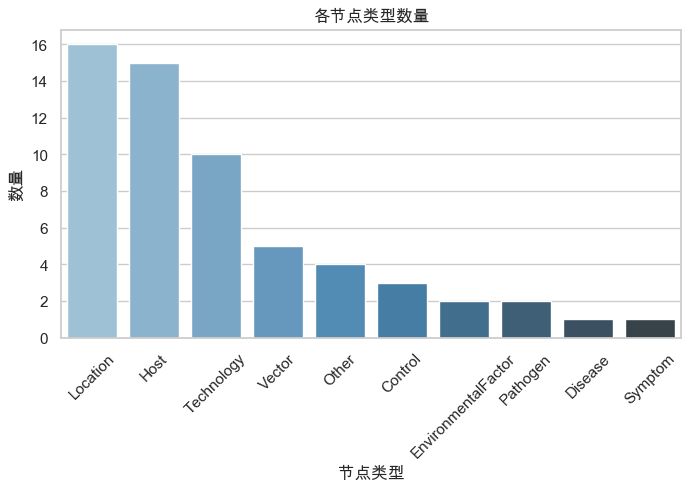

,label,count
0,Location,16
1,Host,15
2,Technology,10
3,Vector,5
4,Other,4
5,Control,3
6,EnvironmentalFactor,2
7,Pathogen,2
8,Disease,1
9,Symptom,1


In [ ]:

query = """
MATCH (n)
RETURN labels(n)[0] AS label, count(n) AS count
ORDER BY count DESC;
"""
with driver.session() as session:
    df_node_types = pd.DataFrame(session.run(query).data())

plt.figure(figsize=(8,4))
sns.barplot(data=df_node_types, x='label', y='count', palette='Blues_d')
plt.title('各节点类型数量')
plt.xlabel('节点类型')
plt.ylabel('数量')
plt.xticks(rotation=45)
plt.show()
df_node_types


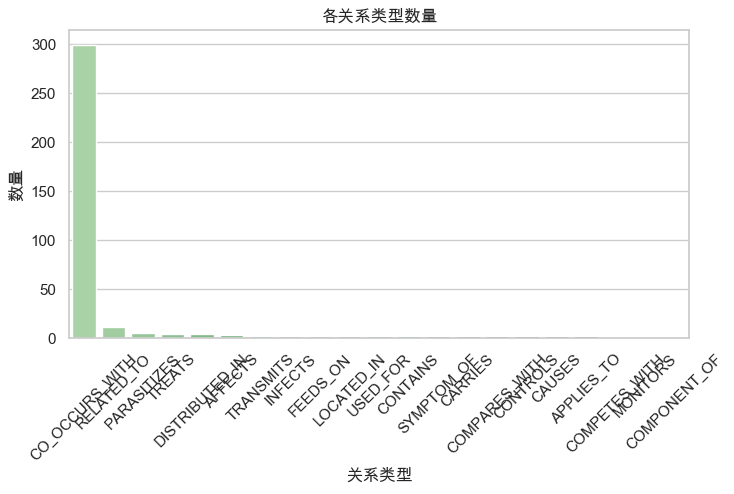

,rel_type,count
0,CO_OCCURS_WITH,299
1,RELATED_TO,12
2,PARASITIZES,6
3,TREATS,5
4,DISTRIBUTED_IN,5
5,AFFECTS,4
6,TRANSMITS,3
7,INFECTS,3
8,FEEDS_ON,3
9,LOCATED_IN,3


In [ ]:

query = """
MATCH ()-[r]->()
RETURN type(r) AS rel_type, count(r) AS count
ORDER BY count DESC;
"""
with driver.session() as session:
    df_rel_types = pd.DataFrame(session.run(query).data())

plt.figure(figsize=(8,4))
sns.barplot(data=df_rel_types, x='rel_type', y='count', palette='Greens_d')
plt.title('各关系类型数量')
plt.xlabel('关系类型')
plt.ylabel('数量')
plt.xticks(rotation=45)
plt.show()
df_rel_types


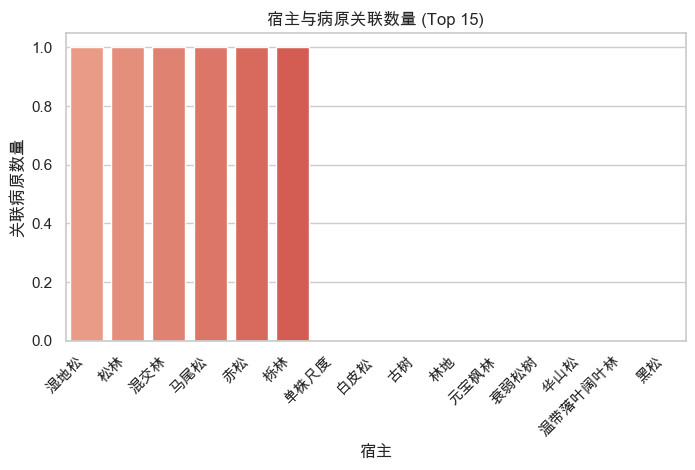

,host,pathogen_links
0,湿地松,1
1,松林,1
2,混交林,1
3,马尾松,1
4,赤松,1
5,栎林,1
6,单株尺度,0
7,白皮松,0
8,古树,0
9,林地,0


In [ ]:

query = """
MATCH (h:Host)
RETURN 
  h.name AS host,
  COUNT { (h)<-[:PARASITIZES]-(:Pathogen) } AS pathogen_links
ORDER BY pathogen_links DESC
LIMIT 15;
"""
with driver.session() as session:
    df_host_risk = pd.DataFrame(session.run(query).data())

plt.figure(figsize=(8,4))
sns.barplot(data=df_host_risk, x='host', y='pathogen_links', palette='Reds_d')
plt.title('宿主与病原关联数量 (Top 15)')
plt.xlabel('宿主')
plt.ylabel('关联病原数量')
plt.xticks(rotation=45, ha='right')
plt.show()
df_host_risk


## 12. GDS 社区划分与高级可视化

In [ ]:

# 可选：删除旧的 GDS 投影（如果存在）
with driver.session() as session:
    try:
        session.run("CALL gds.graph.drop('pwd_full', false)")
        print("已删除旧的 GDS 图投影 pwd_full")
    except Exception as e:
        print("无旧投影或 GDS 未启用:", e)


已删除旧的 GDS 图投影 pwd_full


In [ ]:

# 创建新的 GDS 图投影（使用 cypher project）
projection_query = """
CALL gds.graph.project.cypher(
  'pwd_full',
  'MATCH (n) RETURN id(n) AS id, labels(n) AS labels',
  'MATCH (n)-[r]->(m) RETURN id(n) AS source, id(m) AS target, coalesce(r.weight, 1.0) AS weight'
)
"""
with driver.session() as session:
    try:
        result = session.run(projection_query)
        info = result.single()
        print("GDS 投影创建成功:", info)
    except Exception as e:
        print("创建投影失败，可能未安装 GDS 或缺少权限:", e)


GDS 投影创建成功: <Record nodeQuery='MATCH (n) RETURN id(n) AS id, labels(n) AS labels' relationshipQuery='MATCH (n)-[r]->(m) RETURN id(n) AS source, id(m) AS target, coalesce(r.weight, 1.0) AS weight' graphName='pwd_full' nodeCount=59 relationshipCount=365 projectMillis=2511>


In [ ]:

# 运行 Louvain 社区检测并可视化社区分布
community_query = """
CALL gds.louvain.stream('pwd_full')
YIELD nodeId, communityId, score
RETURN gds.util.asNode(nodeId).name AS name,
       labels(gds.util.asNode(nodeId))[0] AS label,
       communityId,
       score
ORDER BY communityId, score DESC
"""
with driver.session() as session:
    try:
        records = session.run(community_query).data()
        df_louvain = pd.DataFrame(records)
    except Exception as e:
        df_louvain = pd.DataFrame()
        print("Louvain 执行失败:", e)

if df_louvain.empty:
    print("未获取社区结果，确认 GDS 已正确安装并授权。")
else:
    display(df_louvain.head(20))
    plt.figure(figsize=(6,4))
    sns.countplot(data=df_louvain, x='communityId', palette='PuBu')
    plt.title('社区节点数量分布 (Louvain)')
    plt.xlabel('communityId')
    plt.ylabel('节点数量')
    plt.show()


Louvain 执行失败: {code: Neo.ClientError.Statement.SyntaxError} {message: Unknown procedure output: `score` (line 3, column 28 (offset: 64))
"YIELD nodeId, communityId, score"
                            ^}
未获取社区结果，确认 GDS 已正确安装并授权。


### 12.2 最短路径可视化

In [ ]:
import networkx as nx

In [ ]:

# 可视化任意两节点之间的最短路径（可调整 start_name / end_name）
start_name = 'pine wilt disease'
end_name = 'pinus massoniana'
path_query = """
MATCH (start {name: $start}), (end {name: $end})
CALL {
  WITH start, end
  MATCH path = shortestPath((start)-[*1..4]-(end))
  RETURN path
  LIMIT 1
}
RETURN path;
"""
with driver.session() as session:
    record = session.run(path_query, {"start": start_name, "end": end_name}).single()

if not record or record.get('path') is None:
    print(f"未找到 {start_name} 与 {end_name} 之间的路径，可尝试其他节点或增加长度。")
else:
    path = record['path']
    G = nx.Graph()
    labels_map = {}
    nodes = list(path.nodes)
    for node in nodes:
        node_name = node.get('name', str(node.id))
        label = list(node.labels)[0] if node.labels else 'Node'
        G.add_node(node_name, label=label)
        labels_map[node_name] = label
    rels = list(path.relationships)
    for rel in rels:
        start_node = path.nodes[rel.start_node_id]
        end_node = path.nodes[rel.end_node_id]
        start_name_n = start_node.get('name', str(start_node.id))
        end_name_n = end_node.get('name', str(end_node.id))
        G.add_edge(start_name_n, end_name_n, type=rel.type)
    plt.figure(figsize=(6,4))
    pos = nx.spring_layout(G, seed=42)
    node_colors = ['#ffcc66' if labels_map[n]=='Disease' else '#66b3ff' for n in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color=node_colors)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, arrows=False)
    edge_labels = nx.get_edge_attributes(G, 'type')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title(f"{start_name} → {end_name} 最短路径")
    plt.axis('off')
    plt.show()


未找到 pine wilt disease 与 pinus massoniana 之间的路径，可尝试其他节点或增加长度。


In [ ]:

# 关闭连接（在完成所有查询后执行）
driver.close()
print("Neo4j 连接已关闭。")


Neo4j 连接已关闭。
